In [1]:
import numpy
from numpy import matrix, array, linspace, linalg, append, log10
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

The image illustrates some photons hitting plant-leaf cells. Below the cells is a simplified map of the carbon and nutrient flux. $ \mathrm{r_1} $ represents the rate of carbon assimilated $via$ photosynthesis. We can define the units as $ \mathrm{cmol~C~/~(g~chlorophyll~day)} $. Measuring the mass of chlorophyll in a plant is difficult, especially if one wants to keep them alive during the measurement. So to simplify things, lets assume that when the plant grows, it produces chlorophyll at a constant relative rate to other biomass parts, such ars roots and stems. i.e $\frac{\Delta g~chlorophyll}{\Delta g~total~biomass} = constant$. Also, assume the total composition of chlorophyl and biomass remains constant. Thus, we can define $\mathrm{r_1}$ with units of $ \mathrm{cmol~C~/~(C~mol~plant)} $

<img src="PMF.png" alt="Drawing" style="width: 600px;"/>

To begin a model we make further assumptions:<br>
<br>
* Assume only macro nutrients are absorbed <br>
* Leaf surface area, and hence absorbed photons, increases proportionally with increasing plant size 
* The assimilated carbon is directly proportional to the photosynthetic photon flux density $\left(\mathrm{PPFD},~\mathrm{\mu mol/A/time}\right)$ <br>
  or the amount of photons available for photosynthesis that strike a unit surface area per unit time.
* Let $\nu$ (nu) equal th the proportionality constant: $r_1 = \nu~\mathrm{PPFD}$
* No energy is expended in converting the assimilated carbon into biomass (the actual amount is<br> 
  about 40 % of the total photosynthetic carbon)<br>
* Nutrient absorbtion is directly proportional to plant size and follows Michaelis Menten kinetics
* The total biomass composition remains constant

### Variables <br>
<br>
$r_1$ : assimilated carbon $\mathrm{~~~~{cmol~/~day~/~cmolX}}$ <br>
$r_2$ : carbon going to biomass $\mathrm{~~~~{cmol~/~day~/~cmolX}}$ <br>
$r_3$ : Exudate carbon $\mathrm{~~~~{cmol~/~day~/~cmolX}}$ <br>
$\mu$ : Final plant biomass (carbon + nutrients) $\mathrm{~~~~{cmolX~/~day~/~cmolX}}$ <br>
$\sigma$ : Total nutrient flux $\mathrm{~~~~{mol~/~day~/~cmolX}}$ <br>

### Equations:
<br> <br>
[Michaelis Menten expresion](https://chem.libretexts.org/Bookshelves/Biological_Chemistry/Supplemental_Modules_(Biological_Chemistry)/Enzymes/Enzymatic_Kinetics/Michaelis-Menten_Kinetics) for individual nutrient absorbtion rates $\left(\mathrm{mol/day/cmolX}\right)$, where $C_i$ is the nutrient concentration in solution $\left(\mathrm{mol/\ell}\right)$ and Km is the [Michaelis Menten constant](https://depts.washington.edu/wmatkins/kinetics/michaelis-menten.html): <br>
<br>
\begin{equation}
r_i = \frac{r_{i,max}~C_i}{K_M + C_i}
\tag{0.1}
\end{equation}

<br>
Let $~\sigma~$ equal the total nutrient absorption rate:
<br>

\begin{align}
\sigma = \sum_{}^{} r_i
\tag{0.2}
\end{align}

<br>

[The average biomass composition](https://www.intechopen.com/books/biomass-volume-estimation-and-valorization-for-energy/biomass-compositional-analysis-for-conversion-to-renewable-fuels-and-chemicals):
<br>

\begin{align}
\mathrm{C~H_{\mathit{x}}~O_{\mathit{y}}~N_{\mathit{z_1}}~K_{\mathit{z_2}}~Ca_{\mathit{z_3}}~S_{\mathit{z_4}}~Mg_{\mathit{z_5}}~P_{\mathit{z_6}}} 
\tag{0.3}
\end{align}

<br>
Let $z$ equal the total nutrient to carbon ratio $\left(\mathrm{mol/mol}\right)$: 
<br>

\begin{align}
z = \sum_{}^{} z_i
\tag{0.4}
\end{align}

<br>
Thus, the mass balance may be represented by equation 1 to 3:

\begin{equation}
r_1 = \nu~PPFD
\tag{1}
\end{equation}
<br>
where PPFD is the [photosynthetic photon flux density](https://link.springer.com/article/10.1007/s11099-010-0077-5), $\nu$ is the [assimilated carbon to PPFD constant as](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1080802/) and as $r_2 = \mu$:

\begin{align}
r_1 = \mu + r_3 
\tag{2}
\end{align}

\begin{align}
\sigma = z~\mu
\tag{3}
\end{align}

### Initial conditions and constants

In [2]:
Exo     = 0                      ##  initial Exudates                            (cmol)
Xo      = 1                      ##  initial plant size                          (cmol)
Vo      = 20                     ##  liquid volume                               (l)
pHo     = 5                      ##  initial pH          
OHo     = 10**(pHo - 14)*Vo      ##  initial hydroxide ions                      (mol)
Ho      = 10**(-pHo)*Vo          ##  initial hydronium ions                      (mol)

Nr_max  = 0.1                    ##  Maximum Nitrogen absorption rate            (mol/day/cmol_plant)
Kr_max  = 0.04                   ##  Maximum Potasium absorption rate            (mol/day/cmol_plant)
Car_max = 0.03                   ##  Maximum Calcium absorption rate             (mol/day/cmol_plant)
Sr_max  = 0.01                   ##  Maximum Sulphur absorption rate             (mol/day/cmol_plant)
Mgr_max = 0.01                   ##  Maximum Magnesium absorption rate           (mol/day/cmol_plant)
Pr_max  = 0.01                   ##  Maximum Phosphorus absorption rate          (mol/day/cmol_plant)

NO3o    = 0.015*Vo               ##  initial Nitrogen                            (mol)
NH4o    = 0*Vo                   ##  initial Ammonium                            (mol)
Ko      = 0.006*Vo               ##  initial Potasium                            (mol)
Cao     = 0.005*Vo               ##  initial Calcium                             (mol)
So      = 0.002*Vo               ##  initial Sulphate                            (mol)
Mgo     = 0.002*Vo               ##  initial Magnesium                           (mol)
Po      = 0.001*Vo               ##  initial Phosphate                           (mol)

z1      = 0.1                    ##  Nitrogen to carbon ratio                    (mol/mol)
z2      = 0.04                   ##  Potasium to carbon ratio                    (mol/mol)               
z3      = 0.03                   ##  Calcium to carbon ratio                     (mol/mol)
z4      = 0.01                   ##  Sulphur to carbon ratio                     (mol/mol)
z5      = 0.01                   ##  Magnesium to carbon ratio                   (mol/mol)
z6      = 0.01                   ##  Phosphorus to carbon ratio                  (mol/mol)

PPFD    = 60.48                  ##  photosynthetic photon flux density          (umol/m^2/day)
nu      = 0.16                   ##  Assimilated carbon to PPFD constant         (cmol.m^2/umol/cmol_plant)  
Kw      = 10**(-14)              ##  Water equilibrium constant 
Km      = Nr_max/2               ##  Michaelis Menten constant for N uptake      (mol/l)
Km1     = Kr_max/2               ##  Michaelis Menten constant for K uptake      (mol/l)
Km2     = Car_max/2              ##  Michaelis Menten constant for Ca uptake     (mol/l)
Km3     = Sr_max/2               ##  Michaelis Menten constant for S uptake      (mol/l)
Km4     = Mgr_max/2              ##  Michaelis Menten constant for Mg uptake     (mol/l)
Km5     = Pr_max/2               ##  Michaelis Menten constant for P uptake      (mol/l)
B       = 0.01                   ##  Buffer capacity                             (mol) 

to      = 0                      ##  start time                                  (day)
tend    = 30                     ##  end time                                    (day)
nit     = 1000                   ##  number of returned elements                       

### Functions

We know that pH affects the availability of Nutrients in a plant, this is called Nutrient limitation. However, nutrients are limited at different rates due to pH. A [Trough diagram](https://www.researchgate.net/publication/221928014_Nutrient_Solutions_for_Hydroponic_Systems) shows how each nutrient in a nutrient solution is limited at different pH levels. In our case, we have a function that controls the availability of nutrients according to the pH in the solution. The values are rough estimates of the Trough diagram.

In [3]:
def Nutrient_adjust(var):                                    ##  Nutrient limitation due to pH
    NO3, NH4, K, Ca, S, Mg, P, Ex, X, H, OH, V = var

    Hc = H/V
    pH = -log10(Hc)
    
    x  = 0.5*pH - 2
    xp = -0.5*pH + 4
    
    if 8 >= pH >= 6:       
        
        NO3a = NO3
        NH4a = NH4
        Ka   = K
        Caa  = Ca
        Sa   = S
        Mga  = Mg
        Pa   = xp*P
        
    elif 6 > pH >= 4:
        
        NO3a = x*NO3
        NH4a = x*NH4
        Ka   = x*K
        Caa  = x*Ca
        Sa   = x*S
        Mga  = x*Mg
        Pa   = P
    
    else:
        
        NO3a = 0
        NH4a = 0
        Ka   = 0
        Caa  = 0
        Sa   = 0
        Mga  = 0
        Pa   = 0                      
    
    return [NO3a, NH4a, Ka, Caa, Sa, Mga, Pa] 


Let's take mixing paint as an example to explain nutrient uptake in plants. Let's say you need to make purple paint of a certain hue, value and intensity. To get that purple paint, you need 100 parts black (where the black paint is the base), 10 parts blue 4 parts red and 1 part yellow. The composition of the paint always has to be in those proportions. This is the same in plants, where the 'purple' represents the biomass composition, the black represents Carbon and the blue, red and yellow represent the nutrients. The biomass needs to be at a certain composition (i.e. hue) and that requires that the Carbon and the nutrients be taken into the plant at certain fractions (just like the 10 parts of blue and so on). However, the nutrients in real life ('the paint') will never be available in the correct proportions for the plants so now we can talk about different situations that arise with plants while keeping our paint analogy. <br>
<br>
<img src="Paint.png" width='600' height = '600'>
<br>
For our first scenario, let's say that we are not producing enough of the colour paint (so the maximum amount of blue, red and yellow that can be created is 5, 3, 0.8), it stands to reason that in order to maintain the ratio required to create a purple paint of the required quality then the red, yellow and black paint will have to be stepped down proportionally by the value furthest away from the its maximum value (in this case by a half because the blue is only 50 % available) in order to maintain the acceptable quality. The same thing can happen with plants. If a certain nutrient uptake is at a subpar standard (due to poor nutrient availability) in order to produce the required composition of biomass, then all the other nutrients will have to be stepped down proportionally in order to produce biomass with the right composition. <br>
<br>
<img src="Paint1.png" width="600" height = "600"/>
<br>
For our second scenario, let's say that there is more than enough black paint and there is not enough of the other colours to produce the desired composition of the purple paint. That means that some of the black paint needs to get split off in order to maintain the desired composition. This happens in plants as well. If the Carbon that comes in to the plant through photosynthesis is too much compared to the nutrients, then some of the Carbon gets split off back into the tub to maintain the correct composition in the biomass. The carbon that is split off is called [exudates](https://www.greenfacts.org/glossary/def/exudate-plants.htm). 
<br>
<img src="Paintsplit.png" width='600' height = '600'>
<br>

In [4]:
def res(var):
    NO3, NH4, K, Ca, S, Mg, P, Ex, X, H, OH, V = var 
    
    CNO3, CNH4, CK, CCa, CS, CMg, CP = Nutrient_adjust(var)/V 
    
    CN = CNO3 + CNH4
    
    ra = array([Nr_max*CN/(Km + CN),                             
                Kr_max*CK/(Km1 + CK),
                Car_max*CCa/(Km2 + CCa),
                Sr_max*CS/(Km3 + CS),
                Mgr_max*CMg/(Km4 + CMg),
                Pr_max*CP/(Km5 + CP)])
    
    ns = array([z1, z2, z3, z4, z5, z6])
    
    z = sum(ns)
    
    rr = array([ra[0]/ns[0], ra[1]/ns[1], ra[2]/ns[2], ra[3]/ns[3], ra[4]/ns[4], ra[5]/ns[5]])
    
    for i in range(len(rr)):               ##  Corrects for nutrient limitation
        
        if rr[i] == min(rr):
            
            ra = array([rr[i]*ns[0], rr[i]*ns[1], rr[i]*ns[2], rr[i]*ns[3], rr[i]*ns[4], rr[i]*ns[5]])
            
            sigma = sum(ra)
            
            break
    
    
    M = matrix([[1,  0,  0],        # r1, r3, mu
                [1, -1, -1],
                [0,  0,  z]])        
    
    c = array([nu*PPFD, 0, sigma])
    
    ri = linalg.solve(M, c)
    
    
    if ri[1] < 0:                    
                    
        sigma = z*nu*PPFD 
        
        c = array([nu*PPFD, 0, sigma])
        
        ri = linalg.solve(M, c)
        
        ra = array([sigma*z1/z, sigma*z2/z, sigma*z3/z, sigma*z4/z, sigma*z5/z, sigma*z6/z])
        
    ri = append(ri, ra)

    return ri

In [5]:
def ebbnflow(var, t):
    
    NO3, NH4, K, Ca, S, Mg, P, Ex, X, H, OH, V = var              
    
    N = NO3 + NH4
    Hc = H/V                         
    pH = -log10(Hc)      
    
    if pH > 8 or pH < 4:
        
        return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
    else:

        r = res(var)

        dNO3dt = -(NO3/N)*r[3]*X
        dNH4dt = -(NH4/N)*r[3]*X
        dKdt   = -r[4]*X
        dCadt  = -r[5]*X
        dSdt   = -r[6]*X
        dMgdt  = -r[7]*X
        dPdt   = -r[8]*X
        dExdt  =  r[1]*X
        dXdt   =  r[2]*X
        
        dOHdt  = -(dNO3dt + 2*dSdt + dPdt)
        dHdt   = -(dNH4dt + dKdt + 2*dMgdt + 2*dCadt)
        
        netH   =  dHdt - dOHdt
        
        dOHdt_soln = -netH*(OH/(OH + H + B))
        dHdt_soln  =  netH*(H/(OH + H + B))
        
        dVdt = 0

        return [dNO3dt,
                dNH4dt,
                dKdt,
                dCadt,
                dSdt,
                dMgdt,
                dPdt,
                dExdt,
                dXdt,
                dHdt_soln,
                dOHdt_soln,
                dVdt]

In [6]:
def plotter(name):
    
    no3, nh4, k, ca, s, mg, p, ex, x, h, oh, v = C.T
    
    table = {'Exudates Conc' : {'x' : (tsp), 'y' : (ex)},
             'Plantsize'     : {'x' : (tsp), 'y' : (x)},
             'NO3 Conc'      : {'x' : (tsp), 'y' : (no3/v)},
             'K Conc'        : {'x' : (tsp), 'y' : (k/v)},
             'P Conc'        : {'x' : (tsp), 'y' : (p/v)},
             'H Conc'        : {'x' : (tsp), 'y' : (h/v)},
             'S Conc'        : {'x' : (tsp), 'y' : (s/v)},
             'Mg Conc'       : {'x' : (tsp), 'y' : (mg/v)},
             'Ca Conc'       : {'x' : (tsp), 'y' : (ca/v)},
             'NH4 Conc'      : {'x' : (tsp), 'y' : (nh4/v)},
             'OH Conc'       : {'x' : (tsp), 'y' : (oh/v)},
             'Volume'        : {'x' : (tsp), 'y' : (v)},
             'pH'            : {'x' : (tsp), 'y' : (-log10(h/v))},}
    
    plt.figure(name)
    plt.xlabel('Time [Days]')
    plt.ylabel(name)
    
    xvals = table[name]['x']
    yvals = table[name]['y']
    
    
    plt.plot(xvals, yvals)
    plt.title(name)
    
    return plt.show()

In [7]:
yo  = [NO3o, NH4o, Ko, Cao, So, Mgo, Po, Exo, Xo, Ho, OHo, Vo]
tsp = linspace(to, tend, nit)
C   = odeint(ebbnflow, yo, tsp)

In [8]:
no3, nh4, k, ca, s, mg, p, ex, x, h, oh, v = C.T
ph = -log10(h/v)

### Plots

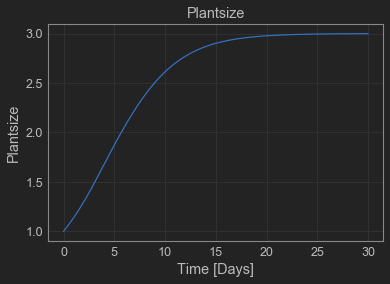

2.9988524752093655

In [9]:
plotter('Plantsize')
max(x)

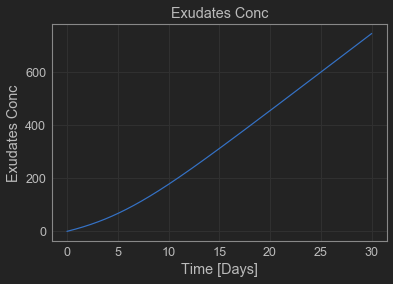

In [10]:
plotter('Exudates Conc')

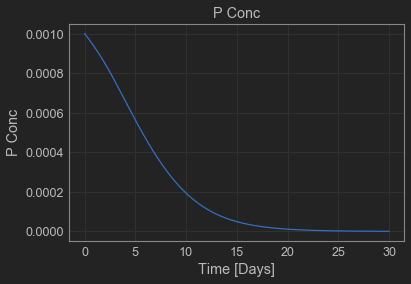

In [11]:
plotter('P Conc')

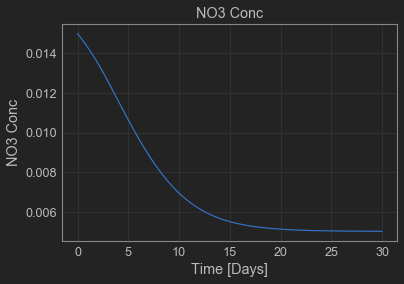

0.10011475247906378

In [12]:
plotter('NO3 Conc')
min(no3)

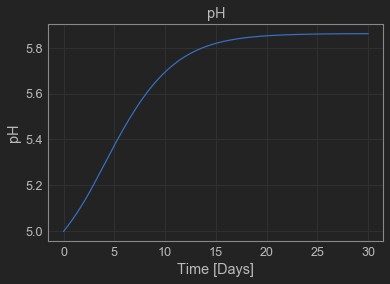

In [13]:
plotter('pH')

It stands to reason that we would like to have the pH with minimum variation, so that we can have optimal plant growth, as we've already seen with the previous plots, pH has a heavy influence on plant growth. We can now optimize our inlet nutrients so that we can have the perfect combination of nutrients so that we have a minimum variance in  the pH.

In [14]:
#Function to find minimum required for any of the nutrients.
def my_minimum(iterable, nut):
    
    iterable = iter(iterable)
    minimum  = next(iterable)
    
    cnt = 0
    
    for i in iterable:
        
        cnt += 1
        
        if i < minimum:
            
            minimum = i
            mins = nut[cnt]
            
    return print('The minimum pH difference is {} and the nutrient tested = {}'.format(minimum, mins))

In [15]:
#Function to return the values of difference in pH
def diffph(nut):
    
    vals = []

    phbeg = -log10(Ho/Vo)

    for NH4oo in nut:

        yo  = [NO3o, NH4oo, Ko, Cao, So, Mgo, Po, Exo, Xo, Ho, OHo, Vo]

        tsp = linspace(to, tend, nit)

        C   = odeint(ebbnflow, yo, tsp)

        no3, nh4, k, ca, s, mg, p, ex, x, h, oh, v = C.T

        ph = -log10(h/v)[-1]

        if ph < phbeg:

            pass

        else: 

            vals.append(abs(ph - phbeg)) 
            
    return vals

In [16]:
nut = numpy.linspace(0, NO3o, 1000)

In [17]:
#This cell takes a super long time to run so just give it some time
my_minimum(diffph(nut), nut)

The minimum pH difference is 0.008908419471763906 and the nutrient tested = 0.015615615615615615


In [18]:
#This answer makes sense, it's about 50% of the No3o